# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

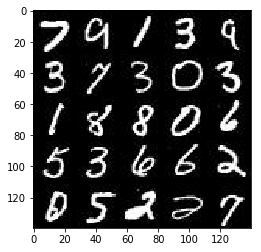

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

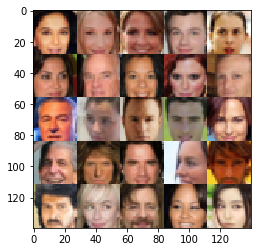

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [204]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape = [None, image_height, image_width, image_channels], name = "inputs_real")
    inputs_z = tf.placeholder(tf.float32, shape = [None, z_dim], name = "inputs_z")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [215]:
layer_init = tf.truncated_normal_initializer(stddev=0.02)

def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha *x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 16, 5, strides=2, padding='same', 
                             activation = leaky_relu,
                             kernel_initializer = layer_init, 
                             bias_initializer = layer_init
                            )
        #14x14x32
        
        x = tf.layers.conv2d(x, 32, 5, strides=2, padding='same',
                             kernel_initializer = layer_init, 
                             bias_initializer = layer_init)
        x = tf.layers.batch_normalization(x, training=True)
        x = leaky_relu(x)
        #7x7x64
        
        x = tf.layers.conv2d(x, 64, 4, strides=1, padding='same',
                             kernel_initializer = layer_init, 
                             bias_initializer = layer_init)
        x = tf.layers.batch_normalization(x, training=True)
        x = leaky_relu(x)
        #7x7x128
        
        x = tf.reshape(x, [-1, 7 * 7 * 64])       
        logits = tf.layers.dense(x, 1,
                                 kernel_initializer = layer_init, 
                                bias_initializer = layer_init)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [222]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        x = tf.layers.dense(z, 7 * 7 * 128, 
                            kernel_initializer = layer_init, 
                            bias_initializer = layer_init,
                            activation = tf.nn.relu)
        x = tf.reshape(x, [-1, 7, 7, 128])
        #7x7
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same', 
                                       kernel_initializer = layer_init, 
                                       bias_initializer = layer_init)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.relu(x)
        #x = tf.layers.dropout(x, 0.4, training = is_train)
        #14x14
        
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same', 
                                       kernel_initializer = layer_init, 
                                       bias_initializer = layer_init,)
        out = tf.tanh(x)
        #28x28xout_channel_dim
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [217]:
smooth = 0.1
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train = True)
    
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, labels = tf.ones_like(d_real_out) * (1. - smooth))
                                )
    d_loss_fake = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.zeros_like(d_fake_out))
                                )
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.ones_like(d_fake_out))
                            )
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [218]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [219]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [220]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[2]
    image_height = data_shape[1]
    image_channels = data_shape[3]
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim = image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, lr: learning_rate})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 50, inputs_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8880... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.4871
Epoch 1/2... Discriminator Loss: 0.6276... Generator Loss: 1.6748
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.6046
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 3.1279
Epoch 1/2... Discriminator Loss: 0.6520... Generator Loss: 1.9430
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.3935
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 1.5972
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.7528
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.4717


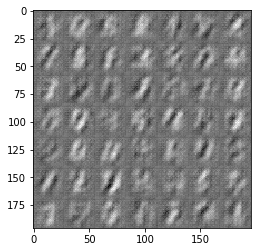

Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.6246
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 1.6029
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.4721
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 1.1247
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.5888
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 1.7908
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.3435


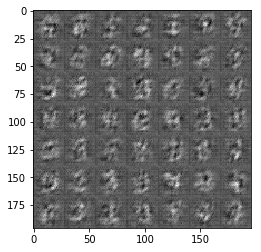

Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.5875
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.8497
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.2564
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 2.3364
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 2.1419
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.4695
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.1917
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 1.4259


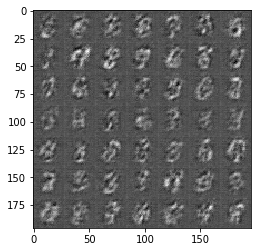

Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 2.2540
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 2.2423
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.8119
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.3395
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 1.9838
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.2146
Epoch 1/2... Discriminator Loss: 0.7105... Generator Loss: 1.6050


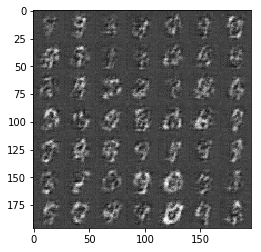

Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 1.5038
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 1.5786
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 1.2364
Epoch 1/2... Discriminator Loss: 0.6955... Generator Loss: 1.5476
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 2.0989
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 1.6173
Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 1.5710
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.9742
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 2.6988


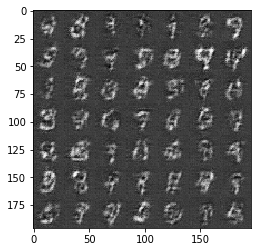

Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.4327
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 2.7758
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 2.0043
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 2.6391
Epoch 2/2... Discriminator Loss: 0.5992... Generator Loss: 1.6161
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 2.1140


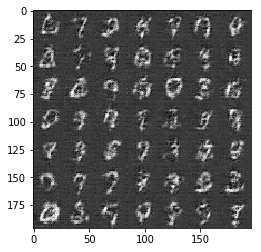

Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.7720
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 1.9421
Epoch 2/2... Discriminator Loss: 0.5373... Generator Loss: 1.9795
Epoch 2/2... Discriminator Loss: 0.5729... Generator Loss: 1.7699
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 3.6601
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 2.5683
Epoch 2/2... Discriminator Loss: 0.5628... Generator Loss: 1.8282
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 2.4055
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 2.5275
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 1.7519


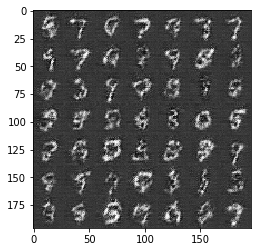

Epoch 2/2... Discriminator Loss: 0.5367... Generator Loss: 1.8805
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 2.1827
Epoch 2/2... Discriminator Loss: 0.6474... Generator Loss: 3.2385
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.8206
Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 1.9086
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 1.9966
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 2.0563
Epoch 2/2... Discriminator Loss: 0.5499... Generator Loss: 2.1055
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.7248


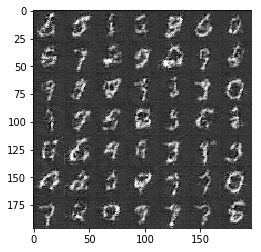

Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 2.6018
Epoch 2/2... Discriminator Loss: 0.6398... Generator Loss: 1.4838
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 3.2204
Epoch 2/2... Discriminator Loss: 0.5382... Generator Loss: 2.6312
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.0260
Epoch 2/2... Discriminator Loss: 0.5715... Generator Loss: 1.8247
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 2.4528
Epoch 2/2... Discriminator Loss: 0.6009... Generator Loss: 3.1329
Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 2.0219


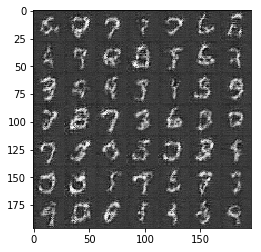

Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.6630... Generator Loss: 1.4196
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.3557


In [221]:
batch_size = 128
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.2062


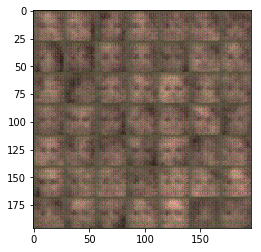

Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.8803


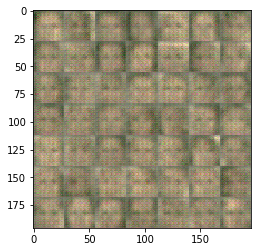

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1200


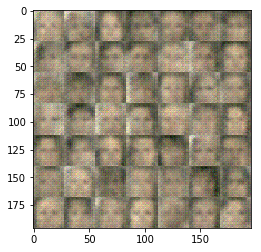

Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.6666... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.7000... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7470


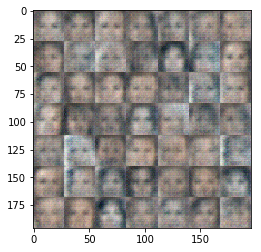

Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.6069


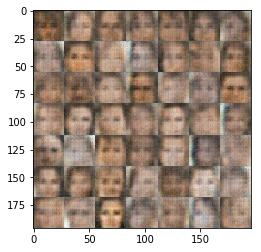

Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 2.0973
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9041


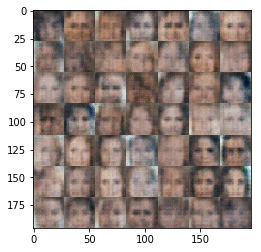

Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9701


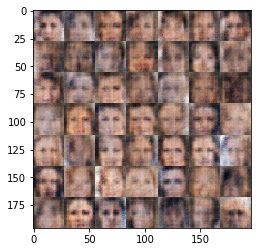

Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6339


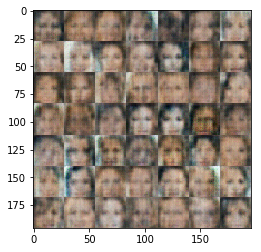

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9808


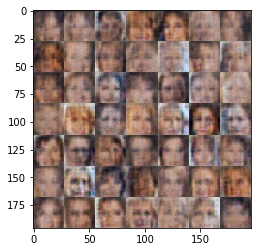

Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8005


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.